In [ ]:
#Abnormality Prediction Regularization
!pip install -q --upgrade keras-hub
!pip install -q --upgrade keras  # Upgrade to Keras 3.

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.1/644.1 kB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 77.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 102.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 34.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompatible.


In [ ]:
import os

#os.environ["KERAS_BACKEND"] = "jax"  # @param ["tensorflow", "jax", "torch"]

import json
import math
import numpy as np
import matplotlib.pyplot as plt

import keras
from keras import losses
from keras import ops
from keras import optimizers
from keras.optimizers import schedules
from keras import metrics
from keras.applications.imagenet_utils import decode_predictions
import keras_hub

# Import tensorflow for [`tf.data`](https://www.tensorflow.org/api_docs/python/tf/data) and its preprocessing functions
import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
def plot_image_gallery(images, titles=None, num_cols=3, figsize=(6, 12)):
    num_images = len(images)
    print(num_images)
    images = np.asarray(images) / 255.0
    images = np.minimum(np.maximum(images, 0.0), 1.0)
    num_rows = (num_images + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize, squeeze=False)
    axes = axes.flatten()  # Flatten in case the axes is a 2D array

    for i, ax in enumerate(axes):
        if i < num_images:
            # Plot the image
            ax.imshow(images[i])
            ax.axis("off")  # Remove axis
            if titles and len(titles) > i:
                ax.set_title(titles[i], fontsize=12)
        else:
            # Turn off the axis for any empty subplot
            ax.axis("off")

    plt.show()
    plt.close()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATASET_DIR_IMG = '/content/drive/MyDrive/CS230_Project/Dental_DB/Classify/Data/'
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
AUTOTUNE = tf.data.AUTOTUNE
tfds.disable_progress_bar()


train_ds = tf.keras.utils.image_dataset_from_directory(DATASET_DIR_IMG, validation_split=0.2, subset="training", seed=21, image_size=(IMAGE_SIZE[0], IMAGE_SIZE[1]),  batch_size=BATCH_SIZE)
val_ds = tf.keras.utils.image_dataset_from_directory(DATASET_DIR_IMG, validation_split=0.2, subset="validation", seed=21, image_size=(IMAGE_SIZE[0], IMAGE_SIZE[1]),  batch_size=BATCH_SIZE)
class_names = train_ds.class_names
print(class_names)
print(len(train_ds))
print(len(val_ds))


Found 1000 files belonging to 2 classes.
Using 800 files for training.
Found 1000 files belonging to 2 classes.
Using 200 files for validation.
['Abnormal', 'Normal']
25
7


In [ ]:
num_classes = len(train_ds.class_names)
print(num_classes)

resizing = keras.layers.Resizing(
    IMAGE_SIZE[0], IMAGE_SIZE[1], crop_to_aspect_ratio=True
)

def package_inputs(image, label):
    return {"images": image, "labels": tf.one_hot(label, num_classes)}

def preprocess_inputs(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    # Staticly resize images as we only iterate the dataset once.
    return image, tf.one_hot(label, num_classes)

train_ds = train_ds.map(package_inputs, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(package_inputs, num_parallel_calls=tf.data.AUTOTUNE)

#train_ds = train_ds.map(preprocess_inputs, num_parallel_calls=AUTOTUNE)
#val_ds = val_ds.map(preprocess_inputs, num_parallel_calls=AUTOTUNE)
augmenters = []
#train_ds = train_ds.batch(BATCH_SIZE)



2


32


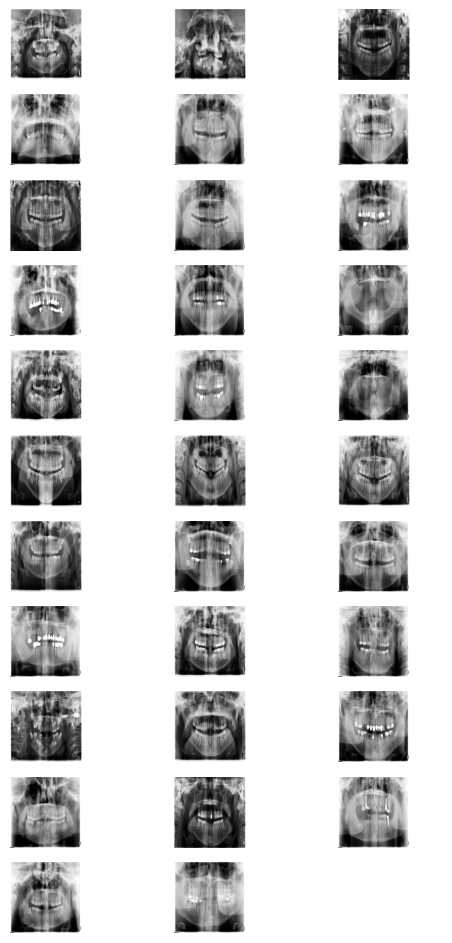

In [ ]:
resize = keras.layers.Resizing(*IMAGE_SIZE, crop_to_aspect_ratio=True)
train_ds = train_ds.map(resize)
val_ds = val_ds.map(resize)



batch = next(iter(train_ds.take(1)))
image_batch = batch["images"]
label_batch = batch["labels"]

plot_image_gallery(
    image_batch,
)

32


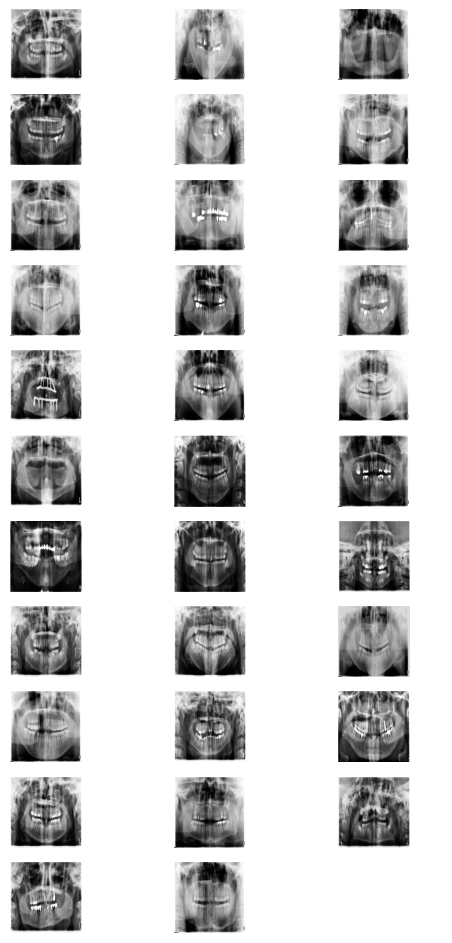

In [ ]:
images = next(iter(train_ds.take(1)))["images"]
plot_image_gallery(images)

32


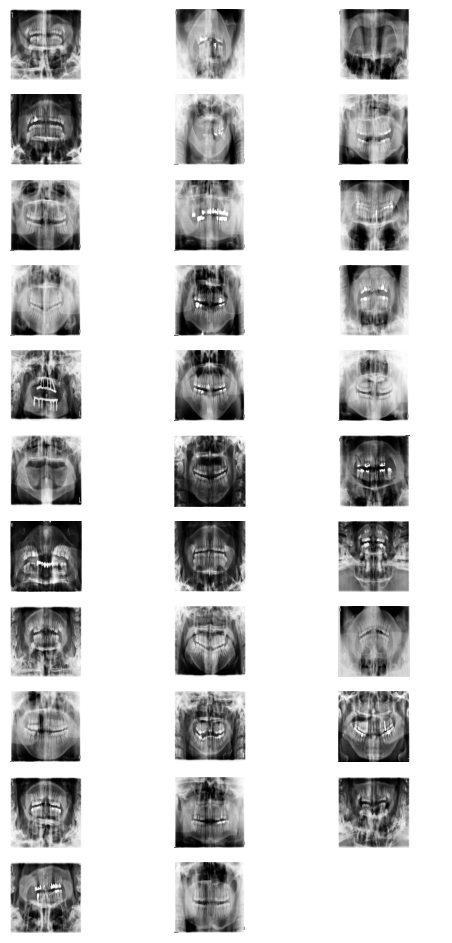

In [ ]:
random_flip = keras.layers.RandomFlip()
augmenters += [random_flip]

images = random_flip(images)
plot_image_gallery(images)

32


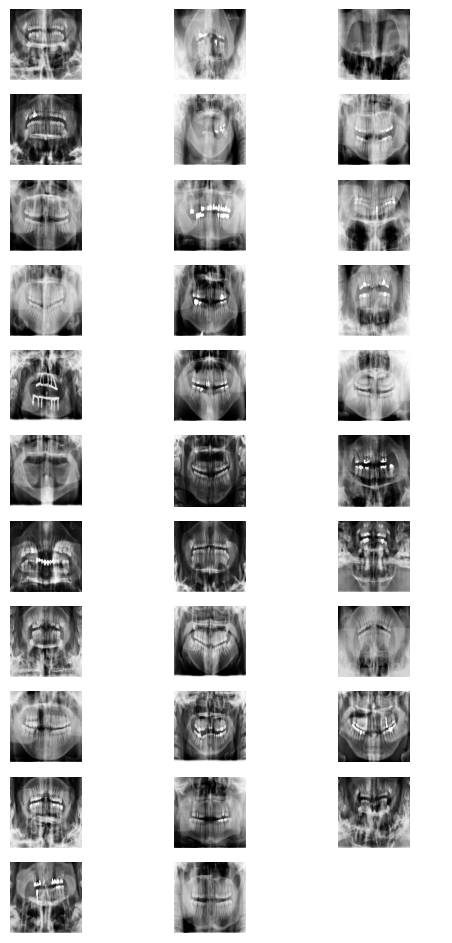

In [ ]:
crop = keras.layers.RandomCrop(
    int(IMAGE_SIZE[0] * 0.9),
    int(IMAGE_SIZE[1] * 0.9),
)

augmenters += [crop]

images = crop(images)
plot_image_gallery(
    images,
)

4


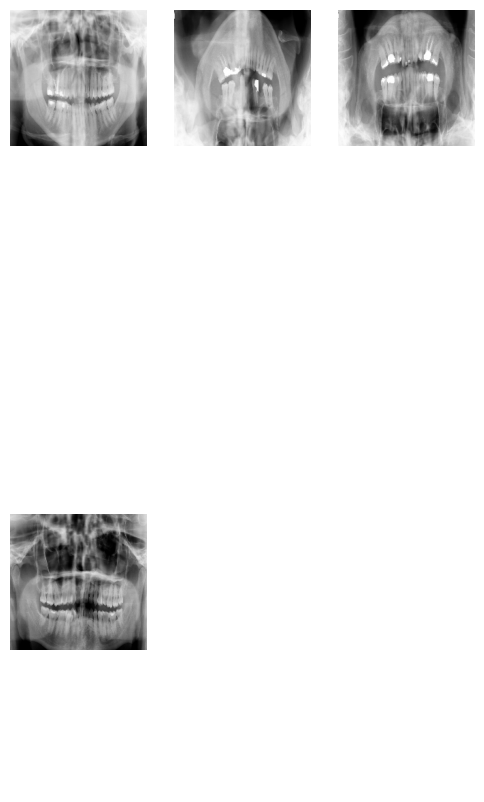

4


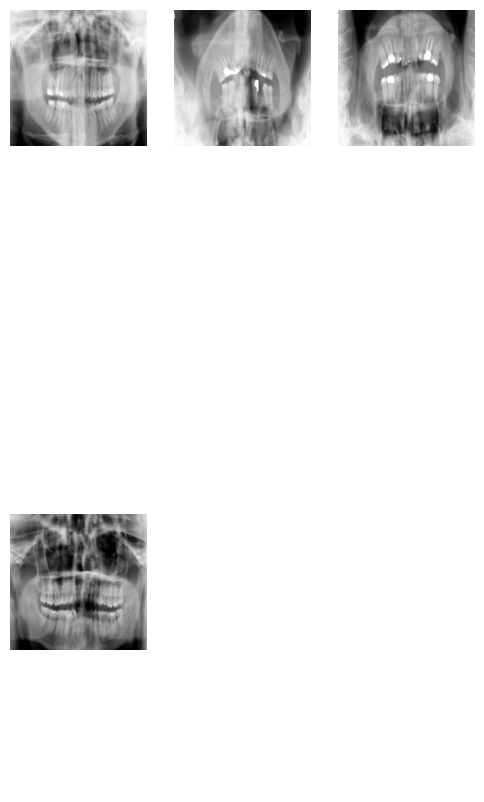

In [ ]:
rotate = keras.layers.RandomRotation((-45 / 360, 45 / 360))

augmenters += [rotate]

image_batch = rotate(images)
plot_image_gallery(images)

resize = keras.layers.Resizing(*IMAGE_SIZE, crop_to_aspect_ratio=True)
augmenters += [resize]

images = resize(images)
plot_image_gallery(images)

32


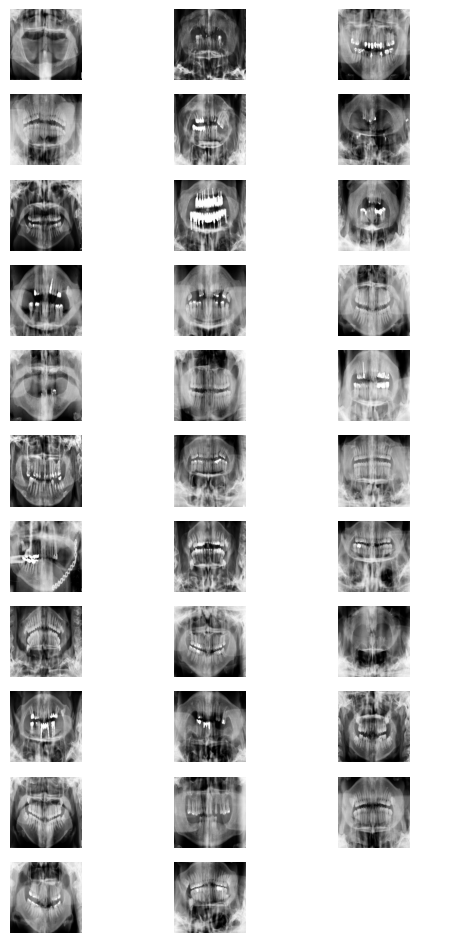

In [ ]:
def create_augmenter_fn(augmenters):
    def augmenter_fn(inputs):
        for augmenter in augmenters:
            inputs["images"] = augmenter(inputs["images"])
        return inputs

    return augmenter_fn


augmenter_fn = create_augmenter_fn(augmenters)
train_ds = train_ds.map(augmenter_fn, num_parallel_calls=tf.data.AUTOTUNE)

image_batch = next(iter(train_ds.take(1)))["images"]
plot_image_gallery(
    image_batch,
)

In [ ]:
inference_resizing = keras.layers.Resizing(*IMAGE_SIZE, crop_to_aspect_ratio=True)


def do_resize(inputs):
    inputs["images"] = inference_resizing(inputs["images"])
    return inputs


val_ds = val_ds.map(do_resize, num_parallel_calls=tf.data.AUTOTUNE)

image_batch = next(iter(val_ds.take(1)))["images"]
plot_image_gallery(
    image_batch,
)

TypeError: in user code:


    TypeError: outer_factory.<locals>.inner_factory.<locals>.tf__do_resize() takes 1 positional argument but 2 were given


In [ ]:
def unpackage_dict(inputs):
    return inputs["images"], inputs["labels"]

train_ds = train_ds.map(unpackage_dict, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(unpackage_dict, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
#Tune Optimizer
def lr_warmup_cosine_decay(
    global_step,
    warmup_steps,
    hold=0,
    total_steps=0,
    start_lr=0.0,
    target_lr=1e-2,
):
    # Cosine decay
    learning_rate = (
        0.5
        * target_lr
        * (
            1
            + ops.cos(
                math.pi
                * ops.convert_to_tensor(
                    global_step - warmup_steps - hold, dtype="float32"
                )
                / ops.convert_to_tensor(
                    total_steps - warmup_steps - hold, dtype="float32"
                )
            )
        )
    )

    warmup_lr = target_lr * (global_step / warmup_steps)

    if hold > 0:
        learning_rate = ops.where(
            global_step > warmup_steps + hold, learning_rate, target_lr
        )

    learning_rate = ops.where(global_step < warmup_steps, warmup_lr, learning_rate)
    return learning_rate


class WarmUpCosineDecay(schedules.LearningRateSchedule):
    def __init__(self, warmup_steps, total_steps, hold, start_lr=0.0, target_lr=1e-2):
        super().__init__()
        self.start_lr = start_lr
        self.target_lr = target_lr
        self.warmup_steps = warmup_steps
        self.total_steps = total_steps
        self.hold = hold

    def __call__(self, step):
        lr = lr_warmup_cosine_decay(
            global_step=step,
            total_steps=self.total_steps,
            warmup_steps=self.warmup_steps,
            start_lr=self.start_lr,
            target_lr=self.target_lr,
            hold=self.hold,
        )
        return ops.where(step > self.total_steps, 0.0, lr)

In [ ]:
total_images = 2000
print(total_images)
EPOCHS = 10
total_steps = (total_images // BATCH_SIZE) * EPOCHS
warmup_steps = int(0.1 * total_steps)
hold_steps = int(0.45 * total_steps)
schedule = WarmUpCosineDecay(
    start_lr=0.05,
    target_lr=1e-2,
    warmup_steps=warmup_steps,
    total_steps=total_steps,
    hold=hold_steps,
)
optimizer = optimizers.SGD(
    weight_decay=5e-4,
    learning_rate=schedule,
    momentum=0.9,
)

2000


In [ ]:
backbone = keras_hub.models.ResNetBackbone(
    input_conv_filters=[64],
    input_conv_kernel_sizes=[7],
    stackwise_num_filters=[64, 64, 64],
    stackwise_num_blocks=[2, 2, 2],
    stackwise_num_strides=[1, 2, 2],
    block_type="basic_block",
)
model = keras.Sequential(
    [
        backbone,
        keras.layers.GlobalMaxPooling2D(),
        keras.layers.Dropout(rate=0.5),
        keras.layers.Dense(2, activation="sigmoid"),
    ]
)

In [ ]:
loss = losses.BinaryCrossentropy(label_smoothing=0.1)

In [ ]:
model = keras_hub.models.ImageClassifier.from_preset(
    "resnet_18_imagenet", num_classes=2
)

In [ ]:
model.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=[
        "accuracy",

    ],
)

In [ ]:
model.fit(
    train_ds,
    epochs=20,
    validation_data=val_ds,
)

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 84ms/step - accuracy: 0.5409 - loss: 2.6576 - val_accuracy: 0.6450 - val_loss: 1.3539
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.5387 - loss: 1.8583 - val_accuracy: 0.6550 - val_loss: 0.6769
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.5757 - loss: 0.8045 - val_accuracy: 0.6600 - val_loss: 0.6519
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.6050 - loss: 0.7279 - val_accuracy: 0.6750 - val_loss: 0.6557
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.5696 - loss: 0.7475 - val_accuracy: 0.6750 - val_loss: 0.7124
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.5799 - loss: 0.7698 - val_accuracy: 0.6750 - val_loss: 0.6602
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.5962 - loss: 0.6883 - val_accuracy: 0.6750 - val_loss: 0.6431
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.5892 - loss: 0.7012 - val_accuracy: 0.6750 - 

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(4, 224, 224, 3)
(4, 2)


In [ ]:
for image_batch, labels_batch in val_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(4, 224, 224, 3)
(4, 2)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(100).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
model = keras_hub.models.ImageClassifier.from_preset(
    "resnet_18_imagenet", num_classes=2
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    metrics=["accuracy"],
)

In [ ]:
history = model.fit(train_ds, epochs=20, validation_data=val_ds)

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 18s 113ms/step - accuracy: 0.5969 - loss: 1.0646 - val_accuracy: 0.6750 - val_loss: 0.6553
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.6442 - loss: 0.6847 - val_accuracy: 0.3750 - val_loss: 1.4192
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.6817 - loss: 0.6521 - val_accuracy: 0.3900 - val_loss: 3.8962
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.7150 - loss: 0.5938 - val_accuracy: 0.3150 - val_loss: 1.1823
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.7851 - loss: 0.5156 - val_accuracy: 0.4400 - val_loss: 0.9048
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.7931 - loss: 0.5265 - val_accuracy: 0.4900 - val_loss: 0.8161
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.7525 - loss: 0.6079 - val_accuracy: 0.3600 - val_loss: 1.1331
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.7522 - loss: 0.5401 - val_accuracy: 0.3600 -

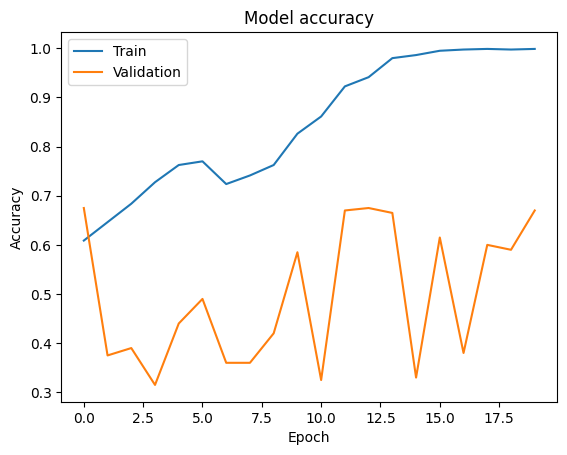

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

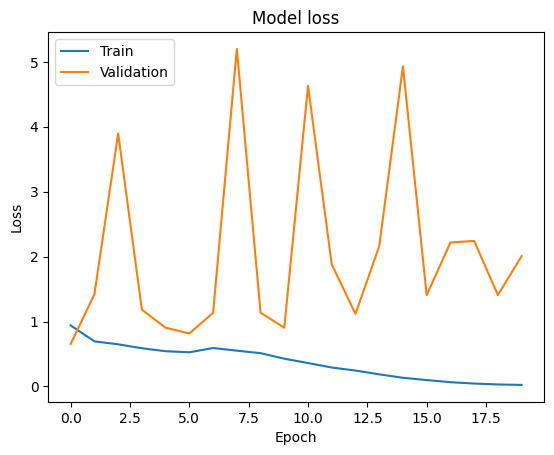

In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
print(model.summary())

Preprocessor: "res_net_image_classifier_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ res_net_image_converter (ResNetImageConverter)                │                   Image size: (224, 224) │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "res_net_image_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                  ┃ Output Shape                       ┃             Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)                   │ (None, None, None, 3)              │                   0 │
├───────────────────────────────────────────────┼────────────────────────────────────┼─────────────────────┤
│ res_net_backbone (ResNetBackbone)             │ (None, None, None, 512)            │          11,186,112 │
├───────────────────────────────────────────────┼────────────────────────────────────┼─────────────────────┤
│ pooler (GlobalAveragePooling2D)               │ (None, 512)                        │                   0 │
├───────────────────────────────────────────────┼────────────────────────────────────┼─────────────────────┤
│ output_dropout (Dropout)                      │ (None, 512)                        │                   0 │
├───────────────────────────────────────────────┼────────────────────────────────────┼─────────────────────┤
│ predictions (Dense)                           │ (None, 2)                          │               1,026 │
└───────────────────────────────────────────────┴────────────────────────────────────┴─────────────────────┘

 Total params: 33,542,216 (127.95 MB)

 Trainable params: 11,177,538 (42.64 MB)

 Non-trainable params: 9,600 (37.50 KB)

 Optimizer params: 22,355,078 (85.28 MB)

None
